### Simulating and Predicting

In [1]:
import os

os.chdir("/home/andre/SmartBinAnalysis/Deliverables")

Our simulator is built on the GridBase class. This grid base was altered to support loading from different files, that is the behavior that was adopted throughout the package. Nonetheless the changes ae incorporated in the save_load class so that everything is seamless. One has total control about the loaded data by sending just the ids that want to be loaded.

Lets now start a GridBase class. There we very little changes so everything should work perfectly from the past. The only difference is that now supports sources from multiple files

To do prediction to data on the fly, notice that the predictor needs past information besides the current timestep to reed information. We include predictor module on the simulation class to abstract this away, but the predictor can be used out of the box. 

We start by the Simulation Class. The Simulation Class is built on top of the GridBase class, so every method from Grid Base can be called from Inside a Simulation. THe simulation class will pre-simulate every rate right on initialization. If learning is set to false from the beginning then the simulation does not  bring to much added value; except that all the computation is offloaded to the beginning.

Iterating with is is easy. One can get the values at each time_step that were pre-simulated; Notice that this differs from getting the data right from GridBAse Because this ways it allows to make calculate from visualization predictions for the required period that you can get by calling the getter a each timestep.


OR one can use the the abstractions that iteratively simulates containers fill data and collections based on pre-simulated value.

Notice that everything is a simple getter. This is required to avoid the high overhead of having to save the data and call R. This way Te R engine call happens only once ans all the predictions and errors are already calculated

In [11]:
import save_load as sl
from simulation import Simulation

PATH = "home/andre/SmartSensro2024"

ids = sl.load_id_containers(path=PATH, name="Rate_Ids")

sim = Simulation(sim_type    = 'real', 
                 ids         = ids, 
                 data_dir    = PATH, 
                 train_split = "01-01-2023", 
                 start_date  = "01-01-2023",
                 end_date    = "01-01-2024",
                 rate_type   = 'crude',
                 info_ver    = '_Corrected_with_metrics',
                 predictQ    = True,
                 savefit_name = "Model_Weights2.csv"
                 )
    

All loaded
Getting in the Pedictor


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


[1] "Fit and Predicted  1 out of  257 bins"
[1] "Fit and Predicted  12 out of  257 bins"
[1] "Fit and Predicted  24 out of  257 bins"
[1] "Fit and Predicted  36 out of  257 bins"
[1] "Fit and Predicted  48 out of  257 bins"
[1] "Fit and Predicted  60 out of  257 bins"
[1] "Fit and Predicted  72 out of  257 bins"
[1] "Fit and Predicted  84 out of  257 bins"
[1] "Fit and Predicted  96 out of  257 bins"
[1] "Fit and Predicted  108 out of  257 bins"
[1] "Fit and Predicted  120 out of  257 bins"
[1] "Fit and Predicted  132 out of  257 bins"
[1] "Fit and Predicted  144 out of  257 bins"
[1] "Fit and Predicted  156 out of  257 bins"
[1] "Fit and Predicted  168 out of  257 bins"
[1] "Fit and Predicted  180 out of  257 bins"
[1] "Fit and Predicted  192 out of  257 bins"
[1] "Fit and Predicted  204 out of  257 bins"
[1] "Fit and Predicted  216 out of  257 bins"
[1] "Fit and Predicted  228 out of  257 bins"
[1] "Fit and Predicted  240 out of  257 bins"
[1] "Fit and Predicted  252 out of  257 bins

Now running a simulation is real easy, just call iteratively *make_collections* ands *advance_timestep* iteratively. The collections functions returns the collected junk, and the advance timestep one returns the number of overflows. Here we make a simulation that runs for 100 timesteps and collections are made at random to 10% of the bins every timestep from the first day that there are values in the dataframe

In [ ]:
import random

import numpy as np
import pandas as pd

overflows = 0
collected_junk = 0

start, end = sim.get_datarange()

data_range = pd.date_range(start, end)

for date in data_range[:100]:

    of, pred_rate, pred_error = sim.advance_timestep(date)
    overflows += np.sum(of)

    idx = random.sample(range(sim.get_num_bins()), sim.get_num_bins()//10)

    collected_junk += np.nansum(sim.make_collections(idx))

print(overflows)
print(collected_junk)

sim.reset_simulation()

131
4695.0


The predictions do not depend of a particular simulation object. If one want to have a another simulation rates; then one should start a simulation object again.

Now we show some ways of plotting data and getting simulation outcomes.

First; we compute a vector mask with the types of garbage

In [4]:
import random

from numpy import nanmean

num_bins = sim.get_num_bins()

trash_type = [sim.get_info(i)['description'].item() for i in range(num_bins)]
vals       = list(set(trash_type)) #keep just unqieu values
c1_idx     = list(filter(lambda i: trash_type[i] == vals[0], range(len(trash_type))))
c2_idx     = list(filter(lambda i: trash_type[i] == vals[1], range(len(trash_type))))

MSE        = sim.predictor.get_MSE()
pred_disp  = sim.predictor.get_pred_errors()

MSEmean    = sim.predictor.get_39mean_MSE()

MSE_c1  = MSE[c1_idx]
MSE_c2  = MSE[c2_idx]
mean_c1 = MSEmean[c1_idx]
mean_c2 = MSEmean[c2_idx]

disp_c1 = pred_disp[c1_idx]
disp_c2 = pred_disp[c2_idx]

print(trash_type[c1_idx[0]])
print(nanmean(MSE_c1))
print(nanmean(disp_c1))
print(nanmean(mean_c1))

print(trash_type[c2_idx[0]])
print(nanmean(MSE_c2))
print(nanmean(disp_c2))
print(nanmean(mean_c2))


Embalagens de papel e cartão
12.533698431861268
11.799812914319908
nan
Mistura de embalagens
9.451417173841856
11.79981291431991
nan


/home/unix/SmartBinAnalysis/Deliverables/predictors.py:41: RuntimeWarning: Mean of empty slice
  return  np.sqrt(np.nanmean(np.square(self.real_error), axis=0))
/home/unix/SmartBinAnalysis/Deliverables/predictors.py:37: RuntimeWarning: Mean of empty slice
  return np.sqrt(np.nanmean(np.square(self.mean39error), axis=0))
/tmp/ipykernel_64051/1530347730.py:27: RuntimeWarning: Mean of empty slice
  print(nanmean(mean_c1))
/tmp/ipykernel_64051/1530347730.py:32: RuntimeWarning: Mean of empty slice
  print(nanmean(mean_c2))


Now its time to plot our bins. Expect a considerable number of bins to be be forecasted with just the mean from the container, because ARIMA models deault to it when the There are no linear relevant dependencies amogn the data. The Residuals Header Varies across datasets. You find it by  looking at import prints, or printing info.keys()

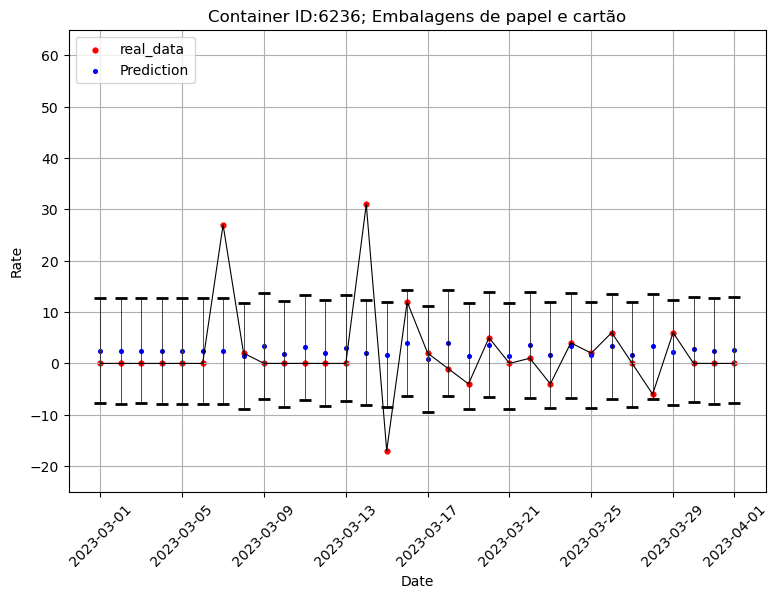

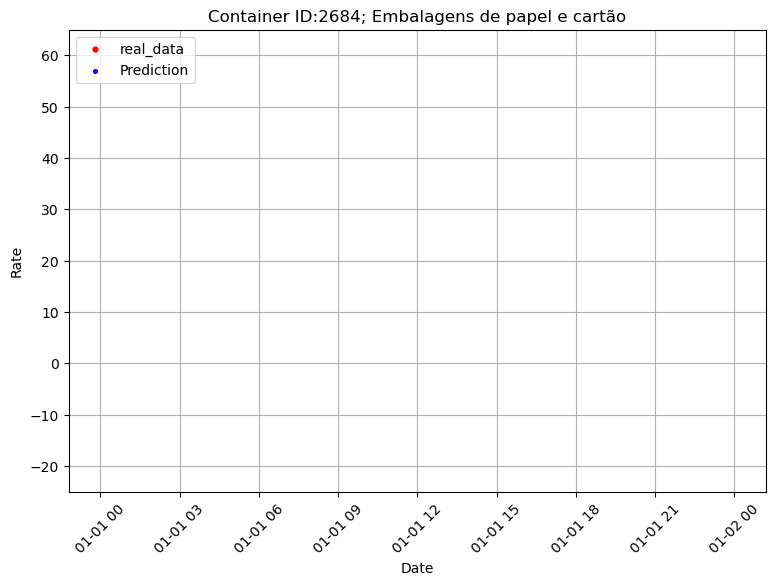

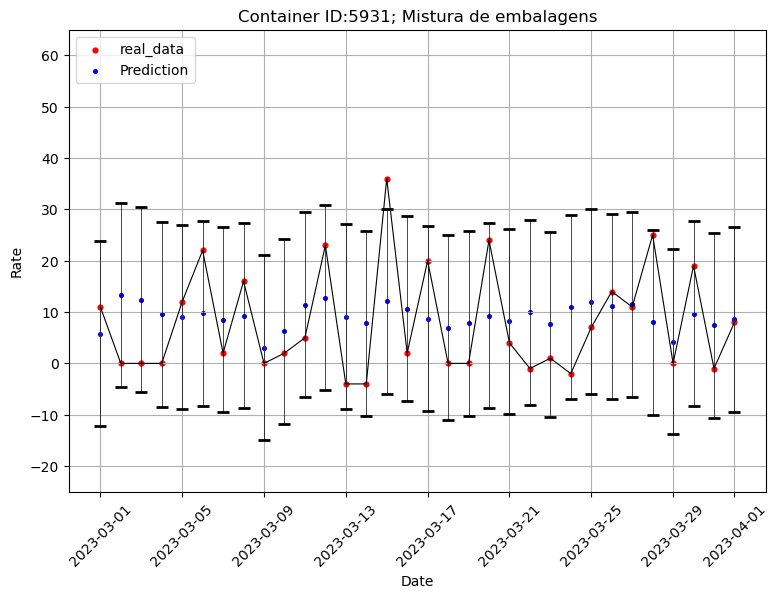

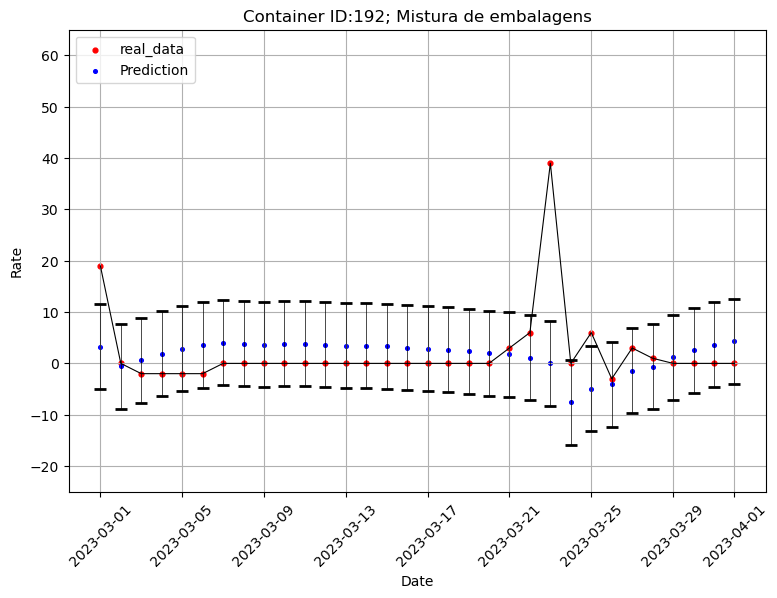

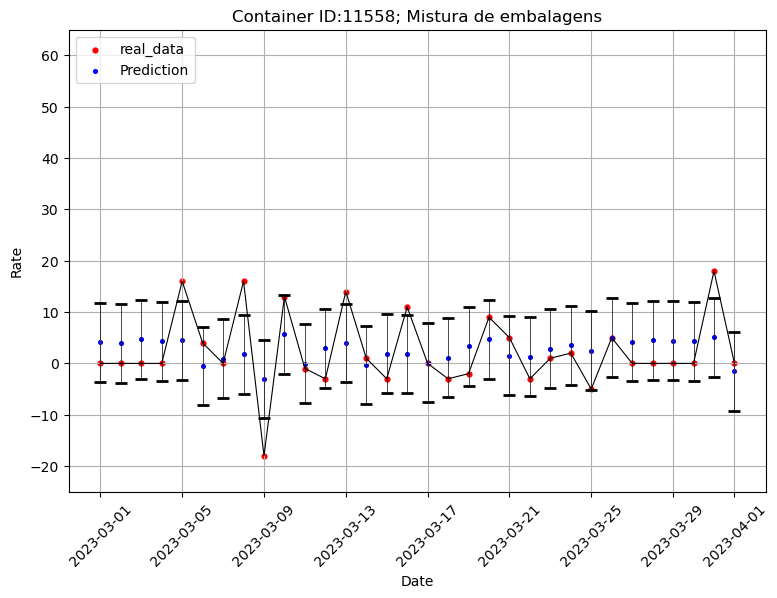

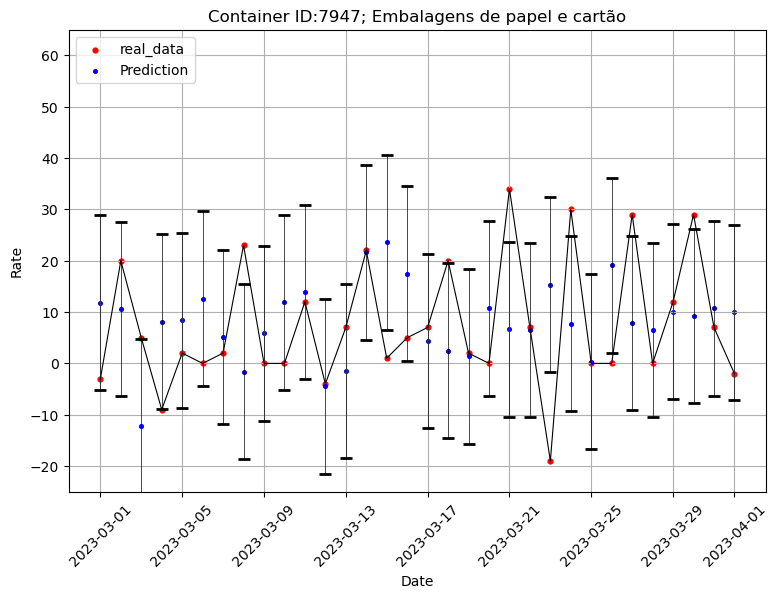

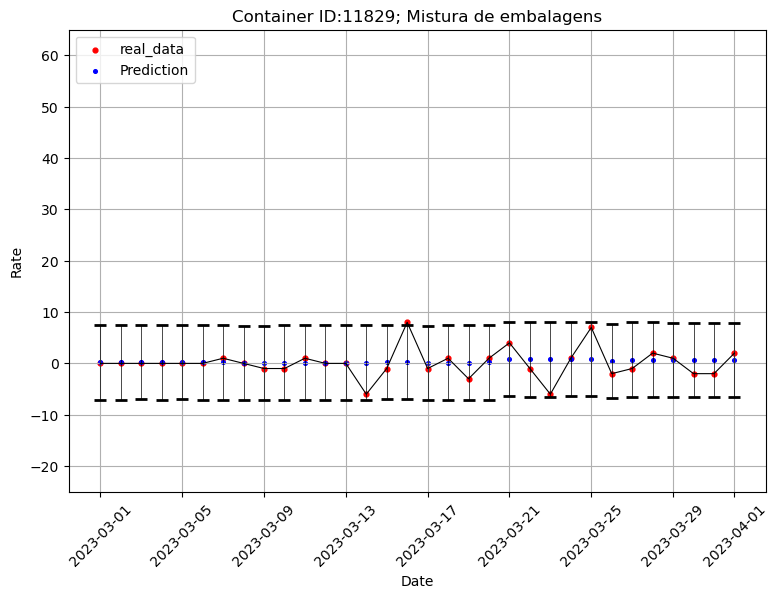

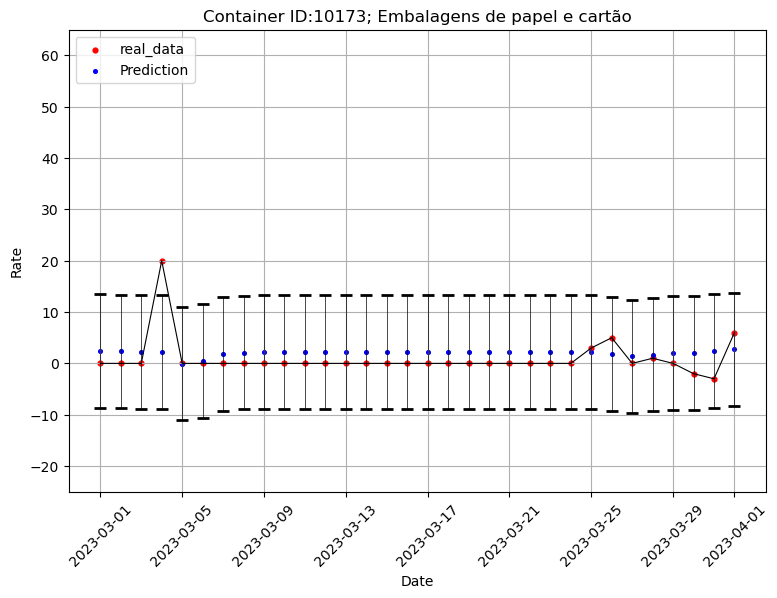

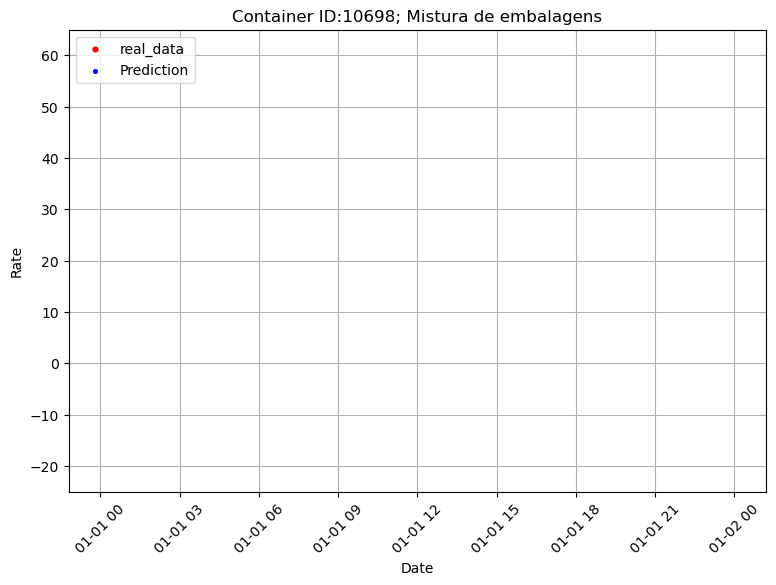

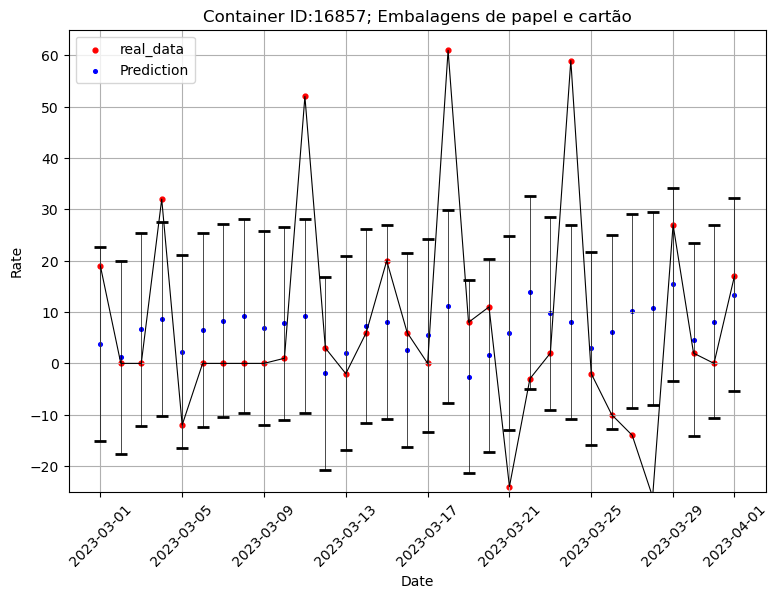

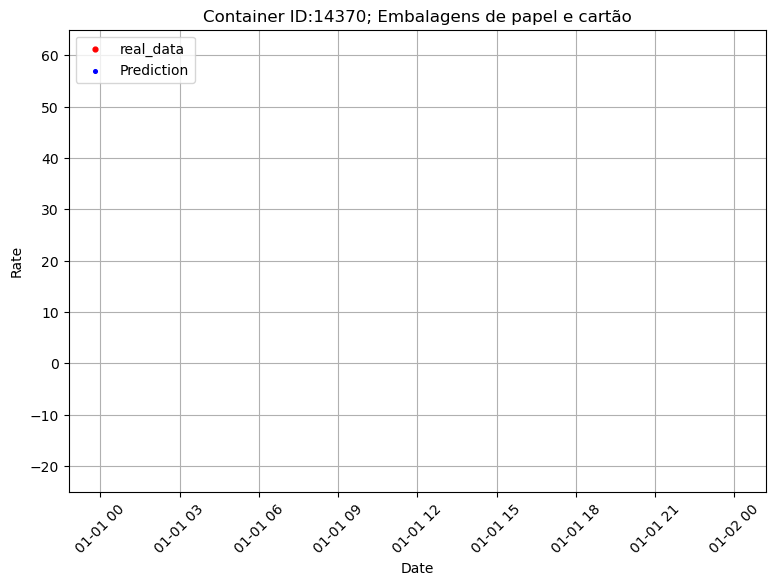

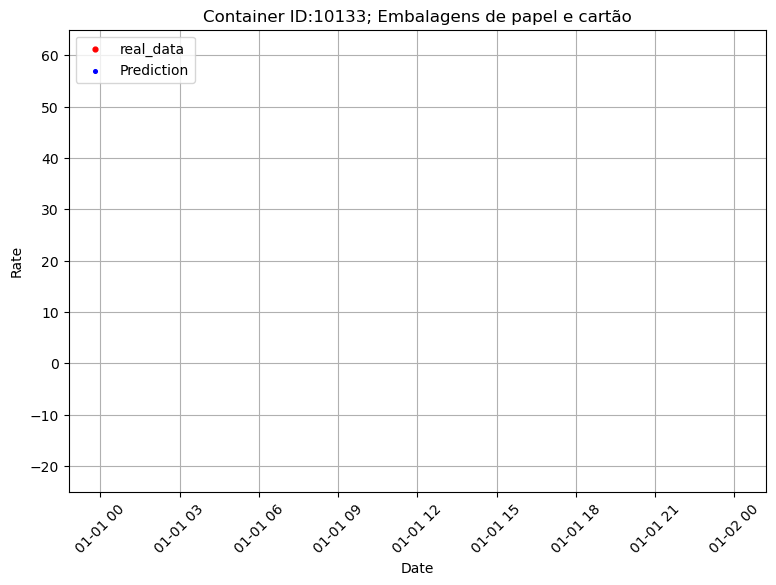

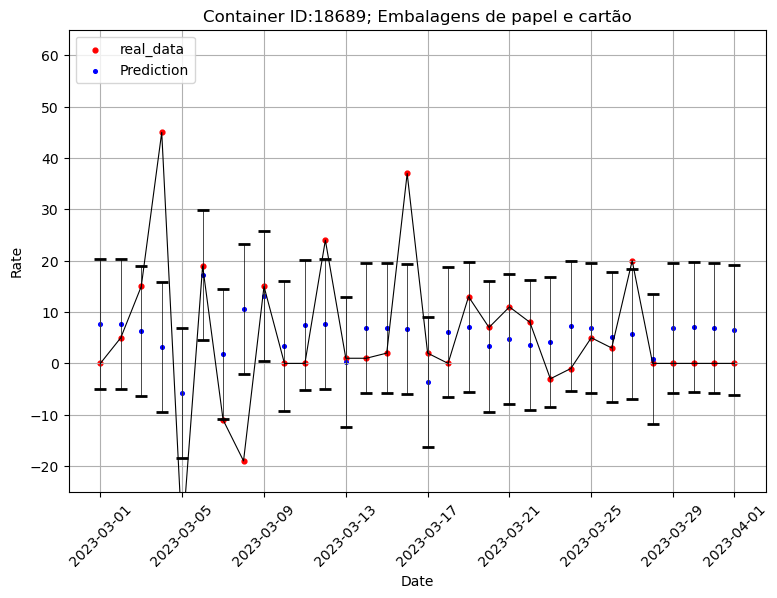

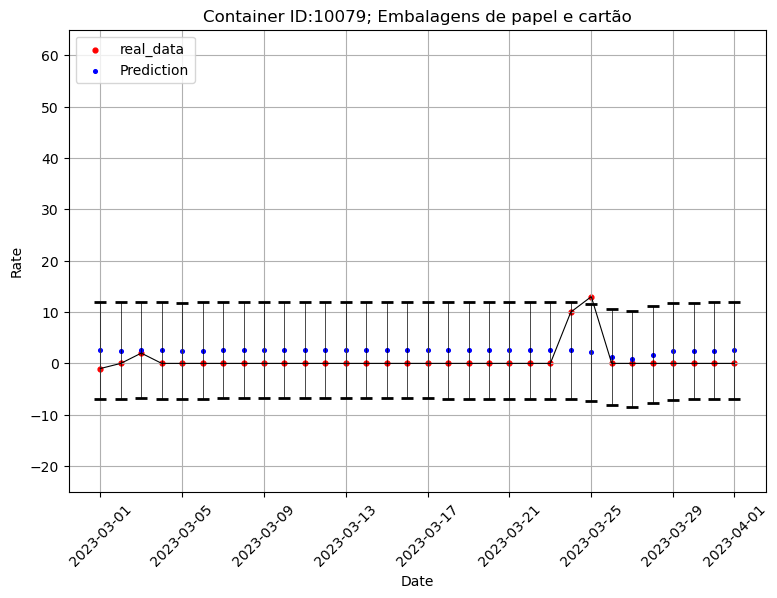

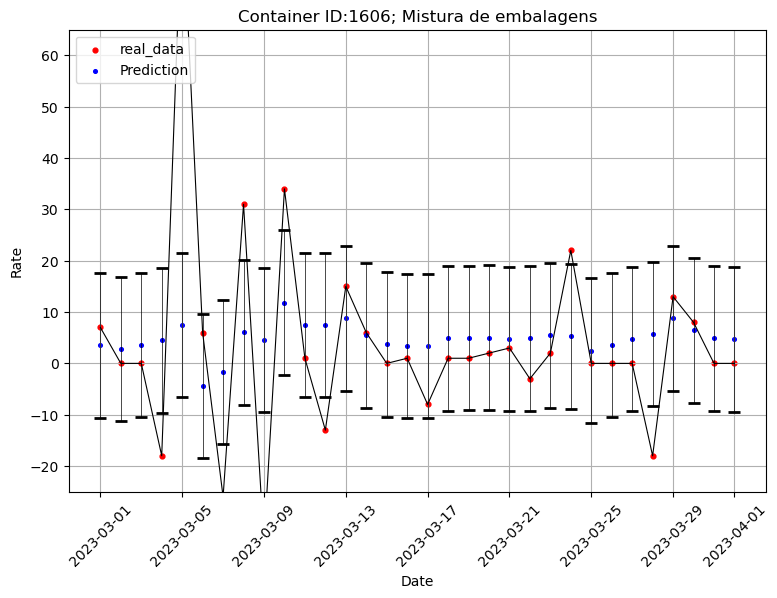

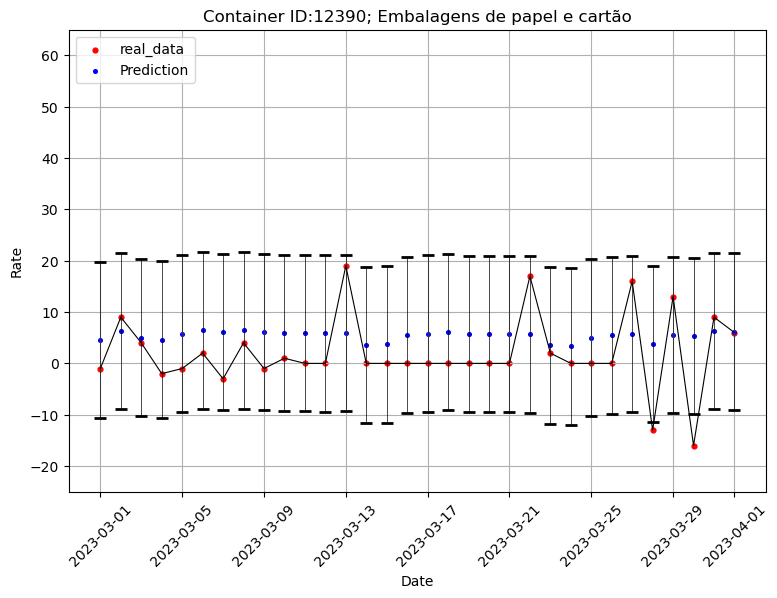

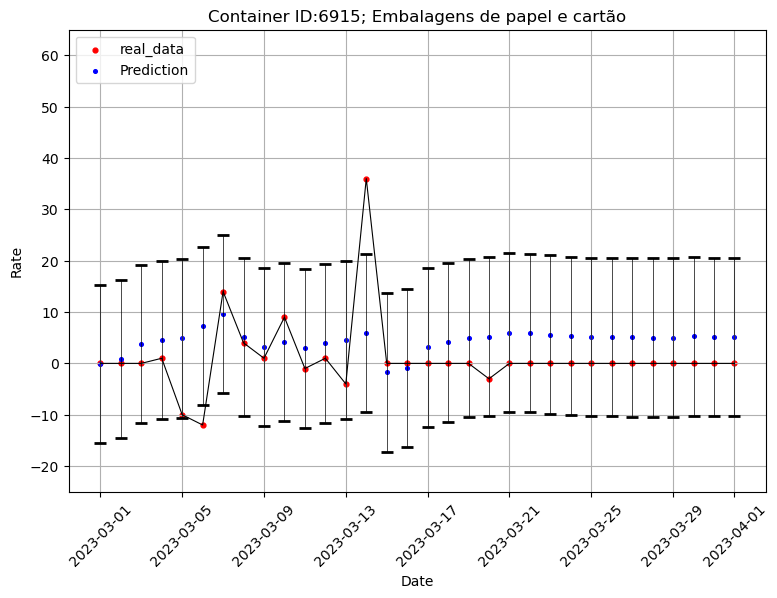

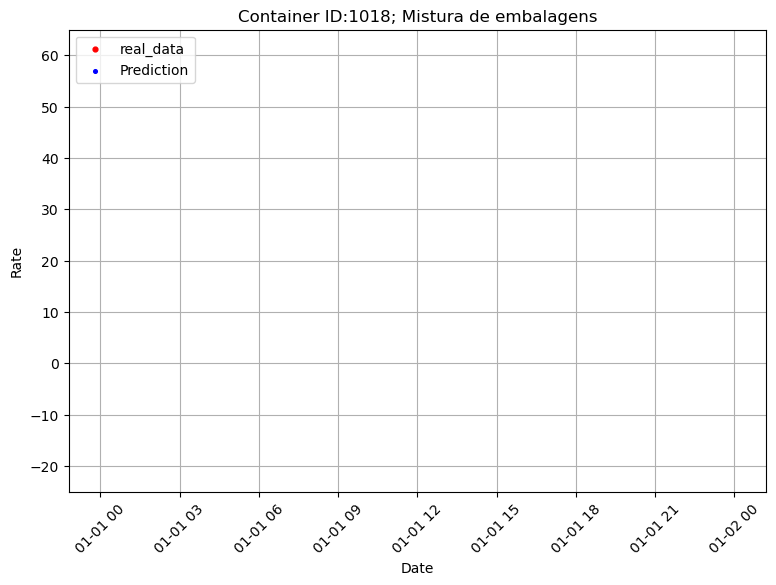

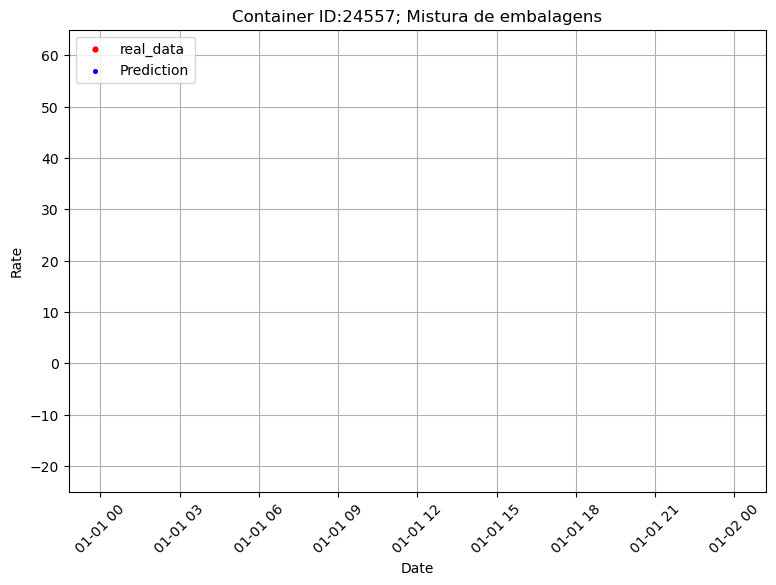

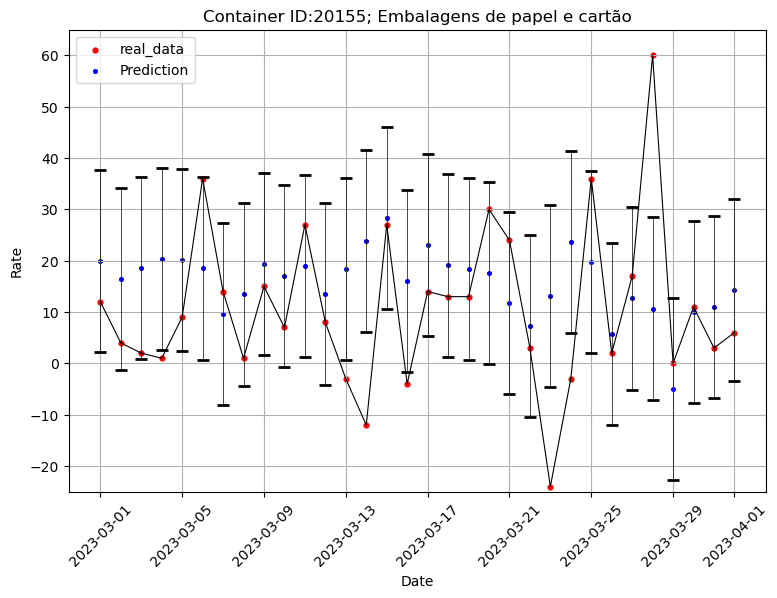

In [ ]:

idexes = random.sample(range(sim.get_num_bins()), min(20, sim.get_num_bins()))

start_date  = '01-03-2023'
end_date    = '01-04-2023'


for index in idexes:
    sim.predictor.plot_predictions(
        index      = index,
        start_date = start_date,
        end_date   = end_date, 
        real_data  = sim.rates,
        info       = sim.get_info(index),
        residuals_header = 'description',
        ylim       = (-25,65)
    )

In [12]:
input_file  = "/home/andre/SmartBinAnalysis/Deliverables/ Model_Weights2.csv"
output_file = "/home/andre/SmartBinAnalysis/Deliverables/ Model_Weights_ids.csv"

with open(input_file, 'r') as infile, \
        open(output_file, 'w') as outfile:

    header = infile.readline().rstrip('\n\r')
    outfile.write("Container ID ," + header + "\n")

    i = 0
    for line in infile:
        
        # Add ID to the beginning of the line
        if i < len(ids):
            new_line = str(ids[i]) + "," + line.rstrip('\n\r') + "\n"
        else:
            # If we run out of IDs, use a default format
            new_line = f"ID_{i}," + line.rstrip('\n\r') + "\n"
        
        # Write the modified line to output file
        outfile.write(new_line)
        i += 1
